In [1]:
# define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Notebook_imports import *
import numpy as np

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models


# Test the main concepts of a DL generator

A Generator yields a tuple of (x,y) and is used to feed data into a deep learning model

Each x/y tuple has the following shape: 

$batchsize * exampleSize * exampleShape$ 

--> The $exampleShape$ could be:
- for 1D vector-data: $width$
- for 2D images: $height * width$: 
- for 3D volumes: $depth * height * width$)


# Create fake data interactively

Please define:

- The total number of $examples$ (the size of the dataset), each $example$ represents one patient/entity
- the $exampleSize$ (number of objects per example), this could represent different timesteps of a multi input generator
- the $batchsize$, meaning how many examples should be yielded in one step

Usually one example would be the path to a file. Which, when loaded will have the given $inputShape$/ $outputShape$.

In this example we will create random numbers define the input and output shape with $inputObjShape$ and $outputObjShape$.

Each random number represents a 1D/2D or 3D object

In [7]:
# Define the size of our fake data
upper_example_limit = 1000
upper_example_size_limit = 8
upper_batchsize_limit = 20

@interact_manual
def create_fake_data(examples_=(1,upper_example_limit), 
                     inputObjects=(1,upper_example_size_limit),
                     outputObjects=(1,upper_example_size_limit),
                     batchsize_=(1,upper_batchsize_limit), 
                     input_obj_shape='(10,10,10)', 
                     ouptut_obj_shape='(10,10,10)'):
    
    global examples, input_objects, output_objects , batchsize, indexes, X, Y, x_dict, y_dict, batches
    examples = examples_
    batchsize = batchsize_
    input_objects = inputObjects
    output_objects = outputObjects
    
    # make sure the dimensions have the correct formating
    # converts a string of int-tuple into a tuple of int '(10,10,10)' --> (10,10,10)
    x_dim = tuple(map(int, input_obj_shape.replace(')', '').replace('(','').split(',')))
    y_dim = tuple(map(int, ouptut_obj_shape.replace(')', '').replace('(','').split(',')))
    
    # create some fake data
    x_dict = {}
    y_dict = {}  
    X = []
    for example in range(examples_):
        # create example data (batchsize x input_objects x input_object_shape and batchsize output_objects x output_object_shape)
        # squeeze unused dimensions
        x_dict[example] = np.squeeze(np.stack([np.round(np.random.sample(x_dim),2)+example for i in range(input_objects)]))
        y_dict[example] = np.squeeze(np.stack([np.round(np.random.sample(y_dim),2)+(10*example) for i in range(output_objects)]))
        # testing purpose if lists are faster than dicts
        #X.append(np.stack([np.round(np.random.sample(x_dim),2)+example for i in range(input_objects)]))
    # index our data, we can use the indicies to select one example or a batch of examples from a list or dictionary
    # By this we dont need to shuffle the data itself, we shuffle only the indexes
    indexes = list(range(len(x_dict)))
    batches = int(np.floor(examples/batchsize))-1
    print('Shape of one patient X: {}, Y: {}'.format(x_dict[0].shape, y_dict[0].shape))

interactive(children=(IntSlider(value=500, description='examples_', max=1000, min=1), IntSlider(value=4, descr…

# Select one batch and yield the corresponding values/shape $(batchsize \times inputObjects \times inputObjShape),(batchsize \times outputObjects \times outputObjShape)$

In [6]:
@interact
def select_batch(selected_batch = (0,batches), shuffle_indexes=False, debug=False):
    global indexes
    
    if shuffle_indexes:
        random.shuffle(indexes)
    # make sure indexes are correctly initialised
    assert len(indexes) == examples, print('len indexes: {}, number of examples: {}'.format(len(indexes), examples))
    
    # define the lower/upper index slicing borders of the current batch
    start_idx = selected_batch*batchsize
    end_idx = (selected_batch+1)*batchsize
    
    # we slice the indexes of the current batch from the index list
    batch_indexes = indexes[start_idx: end_idx]
    
    # print the restrictions of the current batch
    print('selected batch: {} of {} with a batchsize of {} and total {} examples'.format(selected_batch, batches, batchsize, examples))
    print('start idx: {}, end idx: {}'.format(start_idx, end_idx))
    print('Indexes of the currrent batch: {}'.format(batch_indexes))
    print('-'*40)
    
    # stack the entities of the current batch
    batch_x = np.stack([x_dict[k] for k in batch_indexes])
    batch_y = np.stack([y_dict[k] for k in batch_indexes])
    if debug:
        [print('index: {}: value: {}'.format(k, x_dict[k])) for k in batch_indexes]
        [print('index: {}: value: {}'.format(k, y_dict[k])) for k in batch_indexes]
    
    return([batch_x.shape, batch_y.shape])

interactive(children=(IntSlider(value=14, description='selected_batch', max=29), Checkbox(value=False, descrip…

# Performance measurements of different indexing mehtods

In [4]:
from random import randint
# We have a list --> X and a dictionary --> x_dict, 
# len(X) == len(x_dict)
# and X[i] == x_dict[i] for all i in range(len(X))
# We create n random indicies within the range of len(X)
samples = [randint(0, examples-1) for _ in range(10000000)]

In [5]:
%%timeit
# access the list n times, append the value to a new list
temp = None
for i in samples:
    temp = X[i]
    

248 ms ± 2.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%%timeit
# access the dict n times, append the value to a new list
temp = None
for i in samples:
    temp = x_dict[i]

398 ms ± 2.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# From Index to one-hot-encoding

In [19]:
import numpy as np

(5, 25)


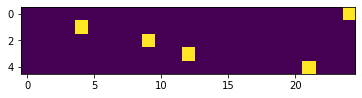

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0.]]


In [69]:
# transform the indices into a one-hot encoding
target_t = 36
timesteps = 25
ind = np.array([24,4,9,12,21])
reps = int(np.ceil(target_t / timesteps))

onehot = np.zeros((ind.size, timesteps))
onehot[np.arange(ind.size), ind] = 1
print(onehot.shape)
plt.imshow(onehot)
plt.show()
print(onehot)

# Phase augmentation - interpret the on-hot vector as ringbuffer

(5, 25)


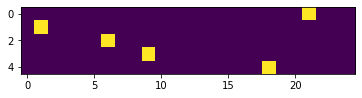

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0.]]


In [70]:
# the img/vectors should represent a ring of heartcycles
rand = random.randint(0, len(onehot))
logging.info(rand)
onehot = np.concatenate([onehot[:,rand:], onehot[:,:rand]], axis=1)
print(onehot.shape)
plt.imshow(onehot)
plt.show()
print(onehot)

# Increase the one-hot vector size

By this we can:

1. smooth the beginning and end of the vector (cycle behaviour)
2. repeat the vector and images to the network input siye instead of cropping it

(5, 100)


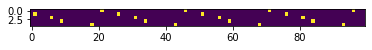

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [71]:
# repeat along t, len(onehot) is than 2 x ceil(t_output/4d.shape[0])
onehot = np.tile(onehot, (1, reps * 2))
print(onehot.shape)
plt.imshow(onehot)
plt.show()
print(onehot)

# Smooth/convolve the five given labels along t

(5, 100)


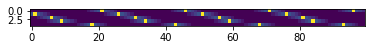

[[ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.1    1.325  2.55   3.775
   5.    20.     5.     3.775  2.55   1.325  0.1    0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.1    1.325  2.55   3.775  5.    20.     5.     3.775  2.55
   1.325  0.1    0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.1    1.325  2.55   3.775
   5.    20.     5.     3.775  2.55   1.325  0.1    0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.1    1.325  2.55   3.775  5.    20.     5.     3.775  2.55 ]
 [ 5.    20.     5.     3.775  2.55   1.325  0.1    0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.1    1.325  2.55   3.775  5.    20.     5.     3.775  2.55
   1.325  0.1    0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0. 

In [72]:
# smooth the onehot with a 1D conv kernel
# create a 1D kernel with linearly increasing/decreasing values in the range(lower,upper),
# insert a '1' in the middle, as this reflect the correct idx
config = {}
SMOOTHING_KERNEL_SIZE = config.get('SMOOTHING_KERNEL_SIZE',10)
SMOOTHING_LOWER_BORDER = config.get('SMOOTHING_LOWER_BORDER',0.1)
SMOOTHING_UPPER_BORDER = config.get('SMOOTHING_UPPER_BORDER',5)
KERNEL = np.concatenate(
    [np.linspace(SMOOTHING_LOWER_BORDER,SMOOTHING_UPPER_BORDER,SMOOTHING_KERNEL_SIZE//2),
     [20],
     np.linspace(SMOOTHING_UPPER_BORDER,SMOOTHING_LOWER_BORDER,SMOOTHING_KERNEL_SIZE//2)])

for idx in range(onehot.shape[0]):
    smoothed = np.convolve(onehot[idx], KERNEL, mode='same')
    onehot[idx] = smoothed

print(onehot.shape)
plt.imshow(onehot)
plt.show()
print(onehot)

# Element-wise maximize two identical splits, this will smooth the beginning and end

(5, 50)


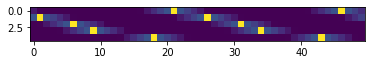

[[ 1.325  0.1    0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.1    1.325  2.55   3.775
   5.    20.     5.     3.775  2.55   1.325  0.1    0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.1    1.325  2.55   3.775  5.    20.     5.     3.775  2.55 ]
 [ 5.    20.     5.     3.775  2.55   1.325  0.1    0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.1    1.325  2.55   3.775  5.    20.     5.     3.775  2.55
   1.325  0.1    0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.1    1.325  2.55   3.775]
 [ 0.     0.1    1.325  2.55   3.775  5.    20.     5.     3.775  2.55
   1.325  0.1    0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.1    1.325  2.55   3.775
   5.    20.     5.     3.775  2.55   1.325  0.1    0.     0.     0.
   0.     0.    

In [73]:
# make sure that we are smooth at the edges (ring-smoothness)
first, second = np.split(onehot,indices_or_sections=2, axis=1)
onehot = np.maximum(first, second)
print(onehot.shape)
plt.imshow(onehot)
plt.show()
print(onehot)

# Crop and transpose to target length

(36, 5)


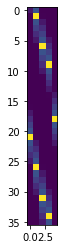

[[ 1.325  5.     0.     0.     0.   ]
 [ 0.1   20.     0.1    0.     0.   ]
 [ 0.     5.     1.325  0.     0.   ]
 [ 0.     3.775  2.55   0.     0.   ]
 [ 0.     2.55   3.775  0.1    0.   ]
 [ 0.     1.325  5.     1.325  0.   ]
 [ 0.     0.1   20.     2.55   0.   ]
 [ 0.     0.     5.     3.775  0.   ]
 [ 0.     0.     3.775  5.     0.   ]
 [ 0.     0.     2.55  20.     0.   ]
 [ 0.     0.     1.325  5.     0.   ]
 [ 0.     0.     0.1    3.775  0.   ]
 [ 0.     0.     0.     2.55   0.   ]
 [ 0.     0.     0.     1.325  0.1  ]
 [ 0.     0.     0.     0.1    1.325]
 [ 0.     0.     0.     0.     2.55 ]
 [ 0.1    0.     0.     0.     3.775]
 [ 1.325  0.     0.     0.     5.   ]
 [ 2.55   0.     0.     0.    20.   ]
 [ 3.775  0.     0.     0.     5.   ]
 [ 5.     0.     0.     0.     3.775]
 [20.     0.1    0.     0.     2.55 ]
 [ 5.     1.325  0.     0.     1.325]
 [ 3.775  2.55   0.     0.     0.1  ]
 [ 2.55   3.775  0.     0.     0.   ]
 [ 1.325  5.     0.     0.     0.   ]
 [ 0.1   20.

In [74]:
# cut and transpose the onehot by the target length
onehot = onehot[:,:target_t]
onehot = onehot.T
print(onehot.shape)
plt.imshow(onehot)
plt.show()
print(onehot)

# Normalise the vector along the second axis 

This can be done either by:

- divide each element by the sum of the elements + epsilon

$\sigma(\mathbf{z})_i = \frac{z_i}{\sum_{j=1}^K z_j + \epsilon} \text{ for } i = 1, \dotsc , K \text{ and } \mathbf z=(z_1,\dotsc,z_K) \in\mathbb{R}^K$

- The standard (unit) softmax function $\sigma : \mathbb{R}^K\to\mathbb{R}^K$ is defined by the formula ([softmax definition](https://en.wikipedia.org/wiki/Softmax_function))

$\sigma(\mathbf{z})_i = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}} \text{ for } i = 1, \dotsc , K \text{ and } \mathbf z=(z_1,\dotsc,z_K) \in\mathbb{R}^K$

Both creates an output where the probability of each class sums to 1. Which can be used together with the Categorical Crossentropy ([link](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html)).



(36, 5)


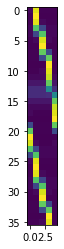

[[2.42447366e-02 9.56422295e-01 6.44432273e-03 6.44432273e-03
  6.44432273e-03]
 [2.27792702e-09 9.99999991e-01 2.27792702e-09 2.06115360e-09
  2.06115360e-09]
 [6.44432273e-03 9.56422295e-01 2.42447366e-02 6.44432273e-03
  6.44432273e-03]
 [1.68337098e-02 7.33907802e-01 2.15591068e-01 1.68337098e-02
  1.68337098e-02]
 [1.68039598e-02 2.15210057e-01 7.32610776e-01 1.85712477e-02
  1.68039598e-02]
 [6.33161732e-03 2.38207180e-02 9.39695329e-01 2.38207180e-02
  6.33161732e-03]
 [2.06115355e-09 2.27792697e-09 9.99999967e-01 2.63974075e-08
  2.06115355e-09]
 [5.12792461e-03 5.12792461e-03 7.61051491e-01 2.23564736e-01
  5.12792461e-03]
 [5.12792461e-03 5.12792461e-03 2.23564736e-01 7.61051491e-01
  5.12792461e-03]
 [2.06115356e-09 2.06115356e-09 2.63974075e-08 9.99999967e-01
  2.06115356e-09]
 [6.44432273e-03 6.44432273e-03 2.42447366e-02 9.56422295e-01
  6.44432273e-03]
 [2.09631831e-02 2.09631831e-02 2.31679003e-02 9.13942550e-01
  2.09631831e-02]
 [5.94986509e-02 5.94986509e-02 5.949865

In [76]:
import sys
# normalise e^{z_ij}/sum(e^{z_i}) (sum(timestep_i) == 1)
for idx in range(onehot.shape[0]):
    smoothed = onehot[idx]
    smoothed = np.exp(smoothed)/sum(np.exp(smoothed))
    onehot[idx] = smoothed
    
print(onehot.shape)
plt.imshow(onehot)
plt.show()
print(onehot)

(36, 5)


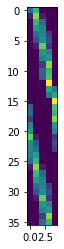

[[0.33333333 0.66666667 0.         0.         0.        ]
 [0.08333333 0.83333333 0.08333333 0.         0.        ]
 [0.         0.66666667 0.33333333 0.         0.        ]
 [0.         0.55555556 0.44444444 0.         0.        ]
 [0.         0.36363636 0.45454545 0.18181818 0.        ]
 [0.         0.25       0.5        0.25       0.        ]
 [0.         0.07692308 0.76923077 0.15384615 0.        ]
 [0.         0.         0.54545455 0.45454545 0.        ]
 [0.         0.         0.45454545 0.54545455 0.        ]
 [0.         0.         0.16666667 0.83333333 0.        ]
 [0.         0.         0.33333333 0.66666667 0.        ]
 [0.         0.         0.28571429 0.71428571 0.        ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.6        0.4       ]
 [0.         0.         0.         0.4        0.6       ]
 [0.         0.         0.         0.         1.        ]
 [0.28571429 0.         0.         0.         0.71428571]
 [0.33333333 0

In [15]:
import sys
# normalise z_ij/sum(z_i) --> (sum(timestep_i) == 1)
for idx in range(onehot.shape[0]):
    smoothed = onehot[idx]
    smoothed = smoothed / (sum(smoothed) + sys.float_info.epsilon)
    onehot[idx] = smoothed
    
print(onehot.shape)
plt.imshow(onehot)
plt.show()
print(onehot)